## PFSA

In [27]:
import pandas as pd
from pathlib import Path
import json
import re
pd.set_option('display.max_rows', 500)


def fix_json_format(content):
    """
    Fix JSON formatting issues in the metadata content.

    Args:
        content (str): The raw content from metadata.json

    Returns:
        str: Properly formatted JSON string
    """
    # Replace single quotes with double quotes
    content = content.replace("'", '"')

    # Replace "nan" with "null" (JSON standard for null/None values)
    content = content.replace('nan', 'null')

    # Add quotes around numeric keys in local_entropy
    local_entropy_pattern = r'"local_entropy":\s*{([^}]+)}'
    if match := re.search(local_entropy_pattern, content):
        local_entropy_content = match.group(1)
        # Add quotes around numeric keys
        fixed_content = re.sub(r'(\d+):', r'"\1":', local_entropy_content)
        content = content.replace(local_entropy_content, fixed_content)

    return content


results = []
results_dir = Path("../data/fairseq_train/local_entropy").resolve()

# 全てのmetadata.jsonファイルを検索
for metadata_file in results_dir.glob('**/metadata.json'):
    grammar_name = metadata_file.parent.name

    # Read metadata
    with open(metadata_file) as f:
        content = f.read()
        content = fix_json_format(content)
        metadata = json.loads(content)


    result = {
        'grammar_name': grammar_name,
        'n_states': metadata['n_states'],
        'N_sym': metadata['N_sym'],
        'mean_length': metadata['mean_length'],
        'sent_global_entropy': metadata['entropy'],
        'sym_global_entropy': metadata['entropy'] / (metadata['mean_length'] + 1)
    }
    for m, entropy in metadata['local_entropy'].items():
        result[f'{m}_local_entropy'] = entropy
    results.append(result)

df = pd.DataFrame(results).sort_values(by=['grammar_name'])
print("len(df)", len(df))
df.head()

len(df) 36


,grammar_name,n_states,N_sym,mean_length,sent_global_entropy,sym_global_entropy,2_local_entropy,3_local_entropy,4_local_entropy,5_local_entropy
0,Q16_S16_s10180,16,16,44.232208,68.355337,1.511209,2.622854,1.801344,1.558135,NaN
1,Q16_S16_s11927,16,16,18.088717,32.121535,1.682750,2.781668,1.965537,1.803755,NaN
2,Q16_S16_s12264,16,16,38.293748,53.412350,1.359309,2.211730,1.514675,1.394096,NaN
3,Q16_S16_s12404,16,16,13.967748,24.053211,1.607003,2.553279,1.721411,1.596821,NaN
4,Q16_S16_s1892,16,16,22.587935,30.381667,1.288017,1.813232,1.413069,1.280593,NaN


## m-gram estimated and exact one

In [28]:
import pandas as pd
from pathlib import Path
import re
pd.set_option('display.max_rows', 500)

results = []
results_dir = Path("../data/fairseq_train/local_entropy").resolve()

# 全てのentropy.csvファイルを検索
for entropy_file in results_dir.glob('*/entropy.csv'):
    experiment_name = Path(entropy_file).parent.name
    data = pd.read_csv(entropy_file)

    exp_result = {
        "grammar_name": experiment_name,
    }
    for n_gram in data['n_gram'].unique():
        n_gram_data = data[data['n_gram'] == n_gram]
        all_entropy = n_gram_data[n_gram_data['dataset'] == 'all']['entropy'].values[0]
        exp_result[f'estimated_{n_gram}_local_entropy'] = all_entropy
    results.append(exp_result)

empirical_df = pd.DataFrame(results).sort_values(by=['grammar_name'])
empirical_df
print("len(empirical_df)", len(empirical_df))
df = pd.merge(df, empirical_df, on="grammar_name", how='left')
df.head()

len(empirical_df) 37


,grammar_name,n_states,N_sym,mean_length,sent_global_entropy,sym_global_entropy,2_local_entropy,3_local_entropy,4_local_entropy,5_local_entropy,estimated_2_local_entropy,estimated_3_local_entropy,estimated_4_local_entropy,estimated_5_local_entropy
0,Q16_S16_s10180,16,16,44.232208,68.355337,1.511209,2.622854,1.801344,1.558135,NaN,2.454465,1.693805,1.474749,1.438202
1,Q16_S16_s11927,16,16,18.088717,32.121535,1.682750,2.781668,1.965537,1.803755,NaN,2.119870,1.531695,1.412584,1.372831
2,Q16_S16_s12264,16,16,38.293748,53.412350,1.359309,2.211730,1.514675,1.394096,NaN,2.075462,1.401087,1.289560,1.281136
3,Q16_S16_s12404,16,16,13.967748,24.053211,1.607003,2.553279,1.721411,1.596821,NaN,2.008469,1.418715,1.316699,1.300905
4,Q16_S16_s1892,16,16,22.587935,30.381667,1.288017,1.813232,1.413069,1.280593,NaN,1.478431,1.217690,1.129705,1.118979


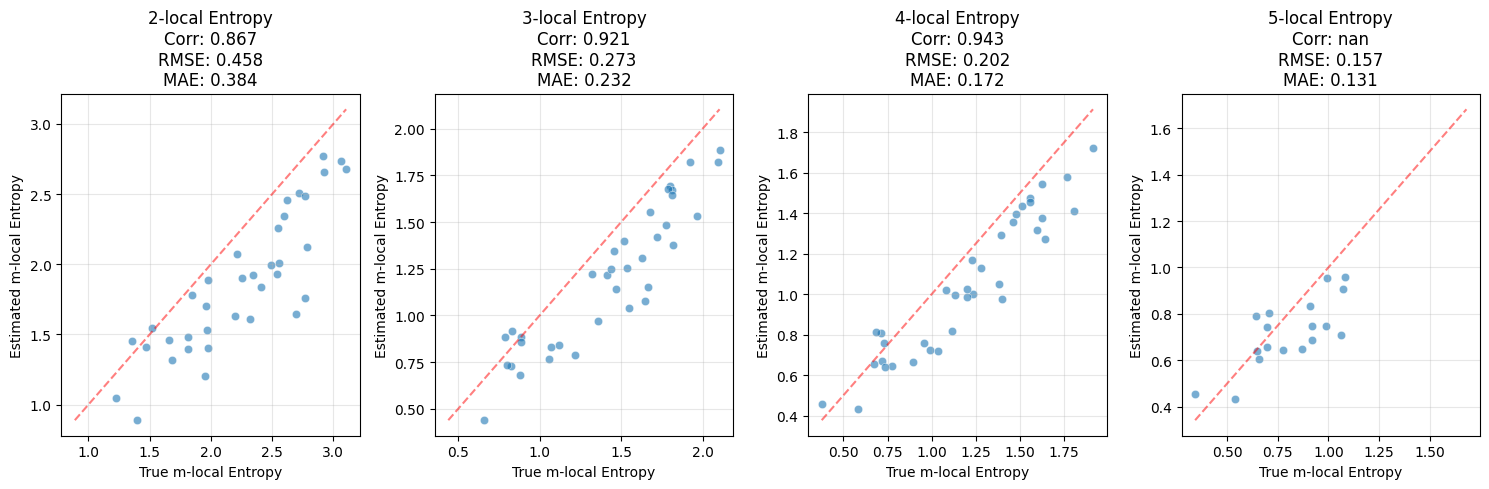


Detailed Statistics:

2-local Entropy:
True - Mean: 2.235, Std: 0.520
Estimated - Mean: 1.857, Std: 0.492
Absolute Error - Mean: 0.384, Std: 0.248

3-local Entropy:
True - Mean: 1.425, Std: 0.415
Estimated - Mean: 1.203, Std: 0.379
Absolute Error - Mean: 0.232, Std: 0.145

4-local Entropy:
True - Mean: 1.195, Std: 0.395
Estimated - Mean: 1.042, Std: 0.346
Absolute Error - Mean: 0.172, Std: 0.106

5-local Entropy:
True - Mean: 0.806, Std: 0.205
Estimated - Mean: 1.009, Std: 0.338
Absolute Error - Mean: 0.131, Std: 0.085


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# 相関係数とRMSEを計算する関数
def evaluate_entropy_estimation(df, m):
    true = df[f'{m}_local_entropy']
    est = df[f'estimated_{m}_local_entropy']

    # 相関係数
    correlation = stats.pearsonr(true, est)[0]
    # RMSE
    rmse = np.sqrt(np.mean((true - est)**2))
    # MAE
    mae = np.mean(np.abs(true - est))

    return correlation, rmse, mae

# プロットと評価を行う
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
ms = [2, 3, 4, 5]  # 評価するm値

for i, m in enumerate(ms):
    true = df[f'{m}_local_entropy']
    est = df[f'estimated_{m}_local_entropy']

    # 散布図
    sns.scatterplot(x=true, y=est, ax=axes[i], alpha=0.6)

    # 対角線（完璧な予測の場合）
    min_val = min(true.min(), est.min())
    max_val = max(true.max(), est.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

    # 評価指標の計算
    corr, rmse, mae = evaluate_entropy_estimation(df, m)

    axes[i].set_title(f'{m}-local Entropy\nCorr: {corr:.3f}\nRMSE: {rmse:.3f}\nMAE: {mae:.3f}')
    axes[i].set_xlabel('True m-local Entropy')
    axes[i].set_ylabel('Estimated m-local Entropy')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 詳細な統計情報を表示
print("\nDetailed Statistics:")
for m in ms:
    true = df[f'{m}_local_entropy']
    est = df[f'estimated_{m}_local_entropy']

    print(f"\n{m}-local Entropy:")
    print(f"True - Mean: {true.mean():.3f}, Std: {true.std():.3f}")
    print(f"Estimated - Mean: {est.mean():.3f}, Std: {est.std():.3f}")
    print(f"Absolute Error - Mean: {np.mean(np.abs(true - est)):.3f}, Std: {np.std(np.abs(true - est)):.3f}")

## entropy distribution of PFSA

/tmp/ipykernel_755576/215755149.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['2-local Entropy', '3-local Entropy', '4-local Entropy', '5-local Entropy'], fontsize=12, color='black')
/tmp/ipykernel_755576/215755149.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Global Entropy'], fontsize=12)


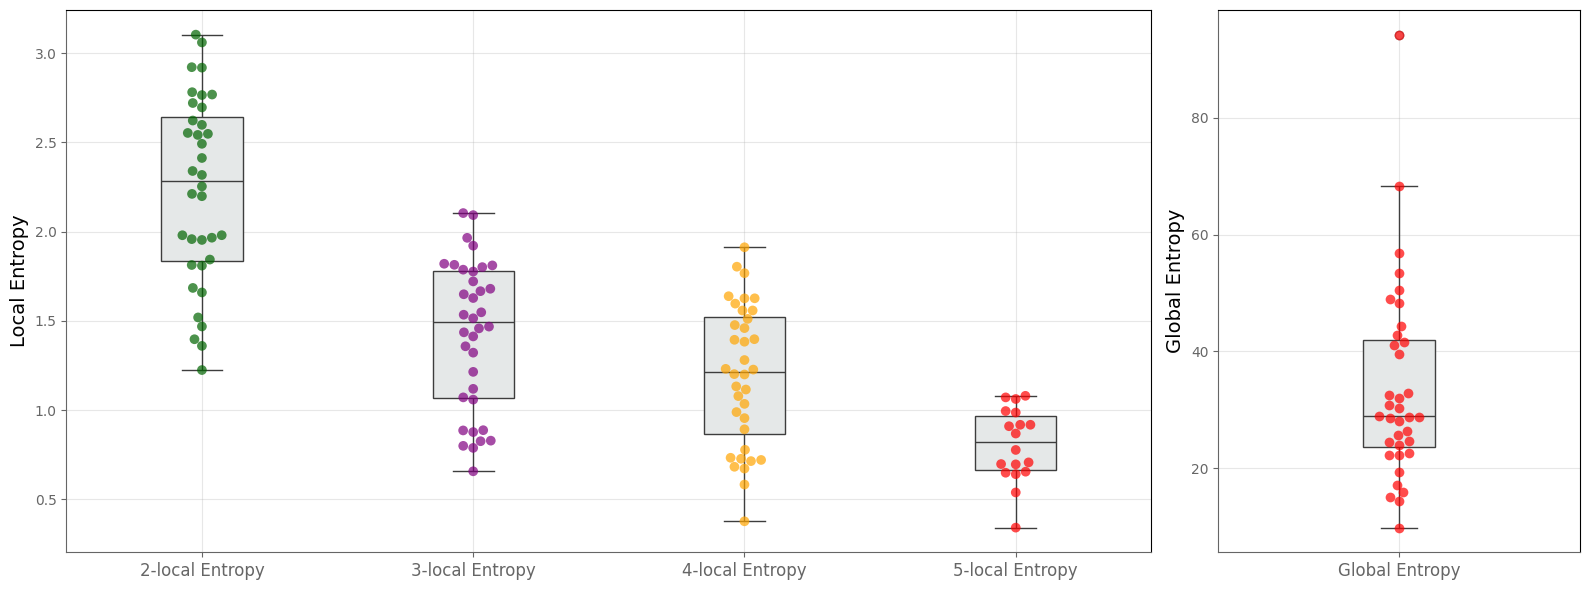


Local Entropy Statistics:
       2_local_entropy  3_local_entropy  4_local_entropy  5_local_entropy
count           36.000           36.000           36.000           18.000
mean             2.235            1.425            1.195            0.806
std              0.520            0.415            0.395            0.205
min              1.225            0.657            0.377            0.341
25%              1.836            1.068            0.864            0.665
50%              2.286            1.491            1.214            0.823
75%              2.641            1.779            1.523            0.969
max              3.104            2.104            1.913            1.080

Global Entropy Statistics:
       global_entropy
count          36.000
mean           33.795
std            16.780
min             9.862
25%            23.719
50%            28.886
75%            41.927
max            94.216


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# データの準備
local_entropy_cols = [f'{m}_local_entropy' for m in [2, 3, 4, 5]]

# Figure with two subplots with different widths (gridspec_kw)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6),
                              gridspec_kw={'width_ratios': [3, 1]})

# カラーパレットの設定
colors = ['darkgreen', 'purple', 'orange', 'red']  # 上のプロットのcolor_mapに合わせる
box_color = '#E5E8E8'

# Local entropy plot
ax1.set_xlim(-0.01, len(local_entropy_cols) - 0.01)
sns.boxplot(data=df[local_entropy_cols], width=0.3, color=box_color,
           flierprops={'marker': 'o', 'markerfacecolor': box_color, 'markeredgecolor': '#7F8C8D'},
           ax=ax1)
sns.swarmplot(data=df[local_entropy_cols], size=7, palette=colors, alpha=0.7, ax=ax1)

# Global entropy plot
ax2.set_xlim(-0.1, 0.1)
sns.boxplot(data=df[['global_entropy']], width=0.2, color=box_color,
           flierprops={'marker': 'o', 'markerfacecolor': box_color, 'markeredgecolor': '#7F8C8D'},
           ax=ax2)
sns.swarmplot(data=df[['global_entropy']], size=7, color='red', alpha=0.7, ax=ax2, label='Global Entropy')  # 赤色を使用

# Customize first subplot
# ax1.set_title('Distribution of Local Entropy Values', fontsize=16)
# ax1.set_xlabel('Local Entropy Type', fontsize=14)
ax1.set_ylabel('Local Entropy', fontsize=14)
ax1.set_xticklabels(['2-local Entropy', '3-local Entropy', '4-local Entropy', '5-local Entropy'], fontsize=12, color='black')
ax1.grid(True, alpha=0.3)

# Customize second subplot
# ax2.set_title('Distribution of Global Entropy', fontsize=16)
# ax2.set_xlabel('Global Entropy', fontsize=14)
ax2.set_ylabel('Global Entropy', fontsize=14)
ax2.set_xticklabels(['Global Entropy'], fontsize=12)
ax2.grid(True, alpha=0.3)

# Common styling
for ax in [ax1, ax2]:
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.tick_params(colors='#666666')

plt.tight_layout()
plt.show()

# 基本統計量を表示
print("\nLocal Entropy Statistics:")
print(df[local_entropy_cols].describe().round(3))
print("\nGlobal Entropy Statistics:")
print(df[['global_entropy']].describe().round(3))

## Model performance

In [20]:
def get_seed(x):
    if "seed" in x:
        return int(re.search(r"seed(\d+)", x).group(1))
    else:
        return None

def get_window(x):
    if "window" in x:
        return int(re.search(r"window(\d+)", x).group(1))
    else:
        return None

model_result_df = pd.read_csv("/home/agiats/Projects/impossible_inherent_entropy/results/length_sampling_local_entropy_results.csv")

# すべてのエントロピーを含めるようにマージ
merged_result_df = pd.merge(
    model_result_df,
    df,
    on="grammar_name",
    how='left'
)
print("len(df)", len(df))
print("len(model_result_df)", len(model_result_df))
print("len(merged_result_df)", len(merged_result_df))

len(df) 36
len(model_result_df) 360
len(merged_result_df) 360


In [ ]:
merged_result_df['sent_KL_divergence'] = (merged_result_df['sym_cross_entropy'] / np.log(2) - (merged_result_df['global_entropy'] / (merged_result_df['mean_length'] + 1)))
merged_result_df['KL_divergence'] = merged_result_df['sent_cross_entropy'] / np.log(2) - merged_result_df['global_entropy']

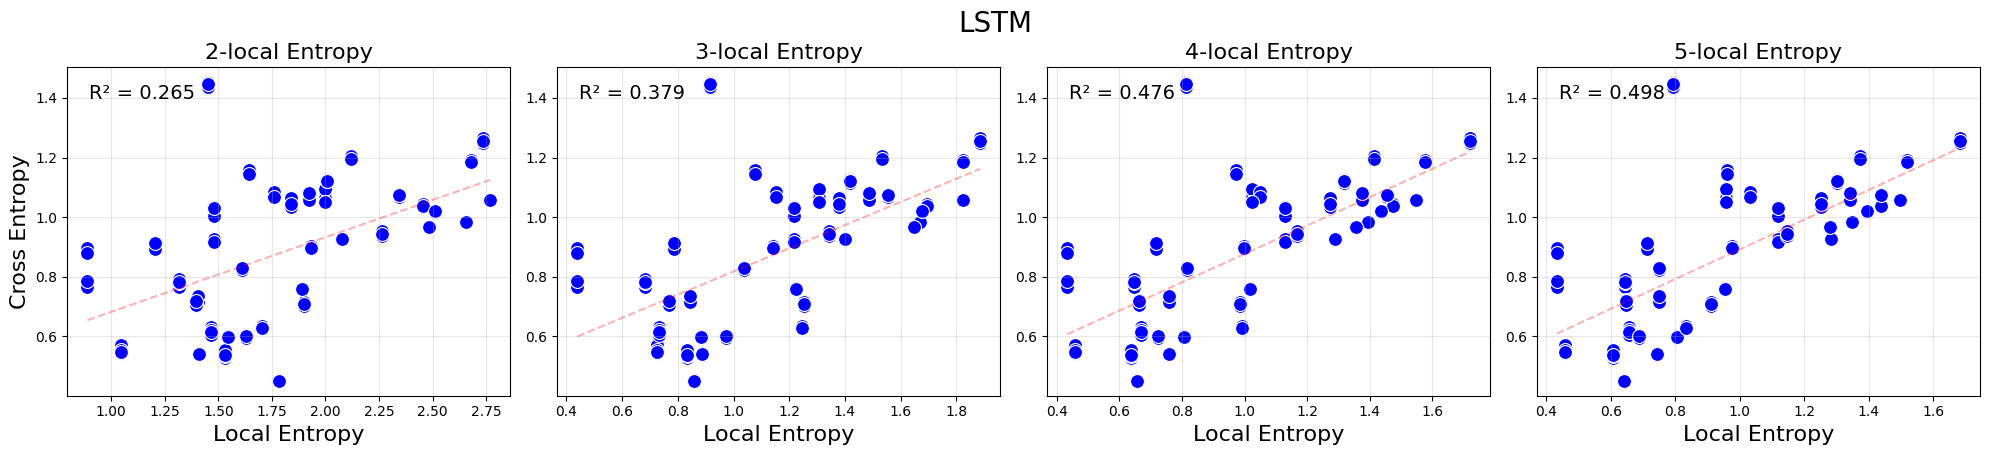

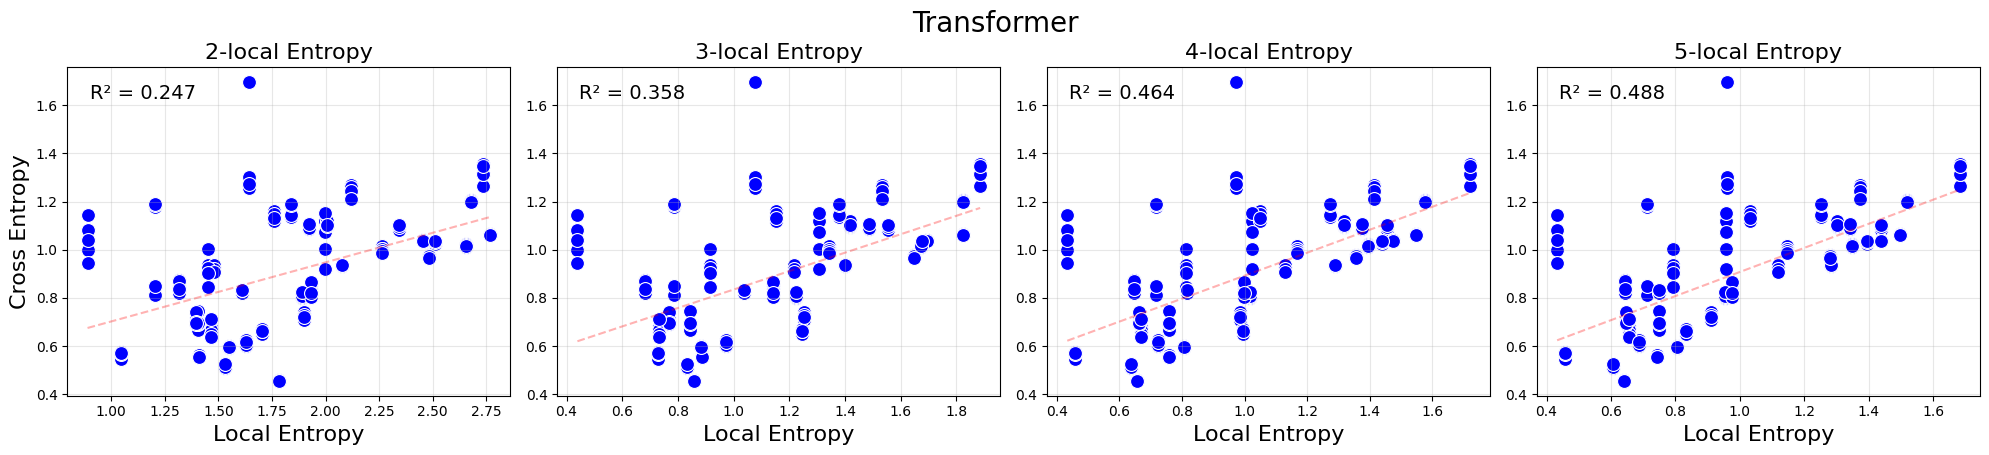

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

estimated = True
# データ型を適切に変換
merged_result_df['sym_cross_entropy'] = pd.to_numeric(merged_result_df['sym_cross_entropy'])

ms = [int(col.replace("_local_entropy", "")) for col in merged_result_df.columns if (col.endswith("_local_entropy") and not col.startswith("estimated_"))]

model_name_map = {
    "lstm": "LSTM",
    "transformer": "Transformer",
    "transformer_tiny": "Transformer (Small)",
    "transformer_4layer": "Transformer"
}

for model_name in merged_result_df['model_name'].unique():
    # モデルごとのデータを取得
    model_data = merged_result_df[merged_result_df['model_name'] == model_name]

    # サブプロットの作成
    fig, axes = plt.subplots(1, len(ms), figsize=(5*len(ms), 5))

    for i, m in enumerate(ms):
        for seed_i in model_data['seed'].unique():
            sns.scatterplot(
                data=model_data[model_data['seed'] == seed_i],
                x=f'{m}_local_entropy' if not estimated else f'estimated_{m}_local_entropy',
                y='sym_cross_entropy',
                ax=axes[i],
                s=100,
                color='blue'
            )

        # # エラーバーを追加
        # for _, row in model_data.iterrows():
        #     axes[i].errorbar(
        #         row[f'{m}_local_entropy'],
        #         row['sym_cross_entropy_mean'],
        #         yerr=row['sym_cross_entropy_std'],
        #         fmt='none',
        #         ecolor='gray',
        #         alpha=0.5
        #     )

        # Add regression line
        x = model_data[f'{m}_local_entropy' if not estimated else f'estimated_{m}_local_entropy']
        y = model_data['sym_cross_entropy']
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        axes[i].plot(line_x, line_y, color='red', linestyle='--', alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        axes[i].text(0.05, 0.95, f'R² = {r_squared:.3f}',
                    transform=axes[i].transAxes,
                    verticalalignment='top',
                    fontsize=14
                    )

        axes[i].set_title(f'{m}-local Entropy', fontsize=16)
        axes[i].set_xlabel(f'Local Entropy', fontsize=16)
        axes[i].set_ylabel('Cross Entropy' if i == 0 else '', fontsize=16)
        axes[i].grid(True, alpha=0.3)

    plt.suptitle(f"{model_name_map[model_name]}", fontsize=20, y=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

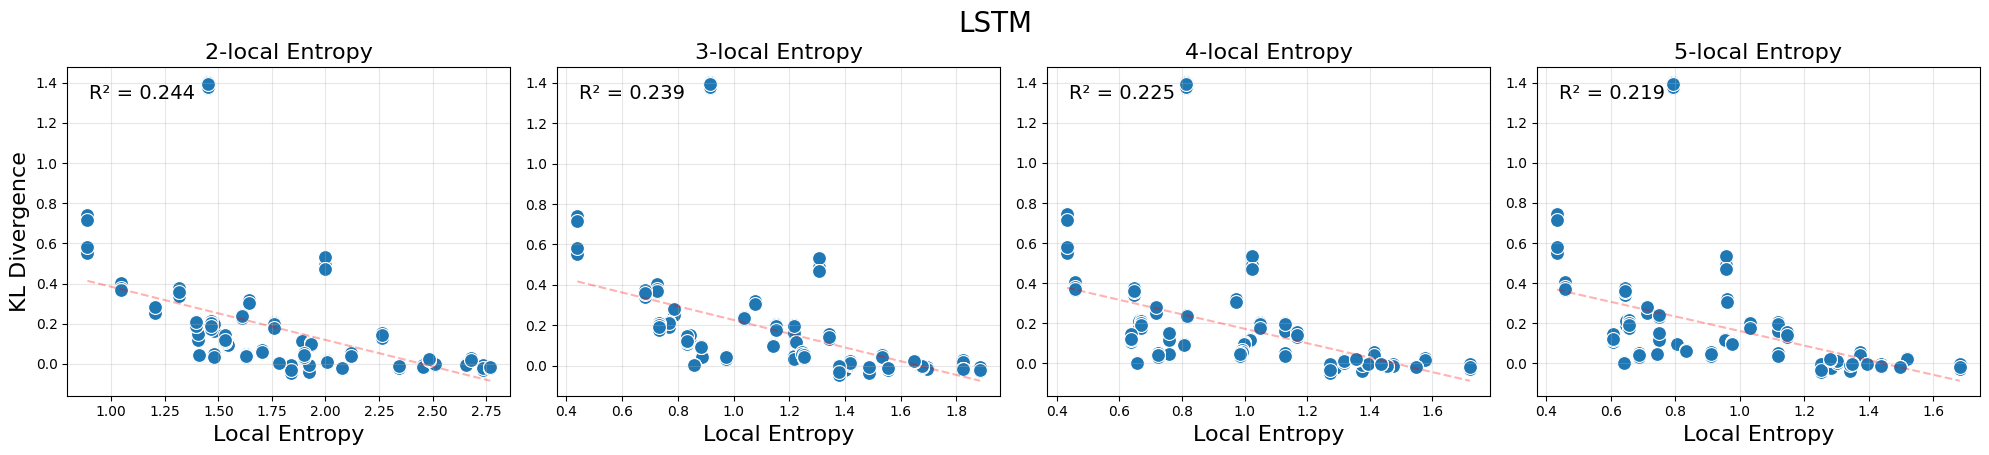

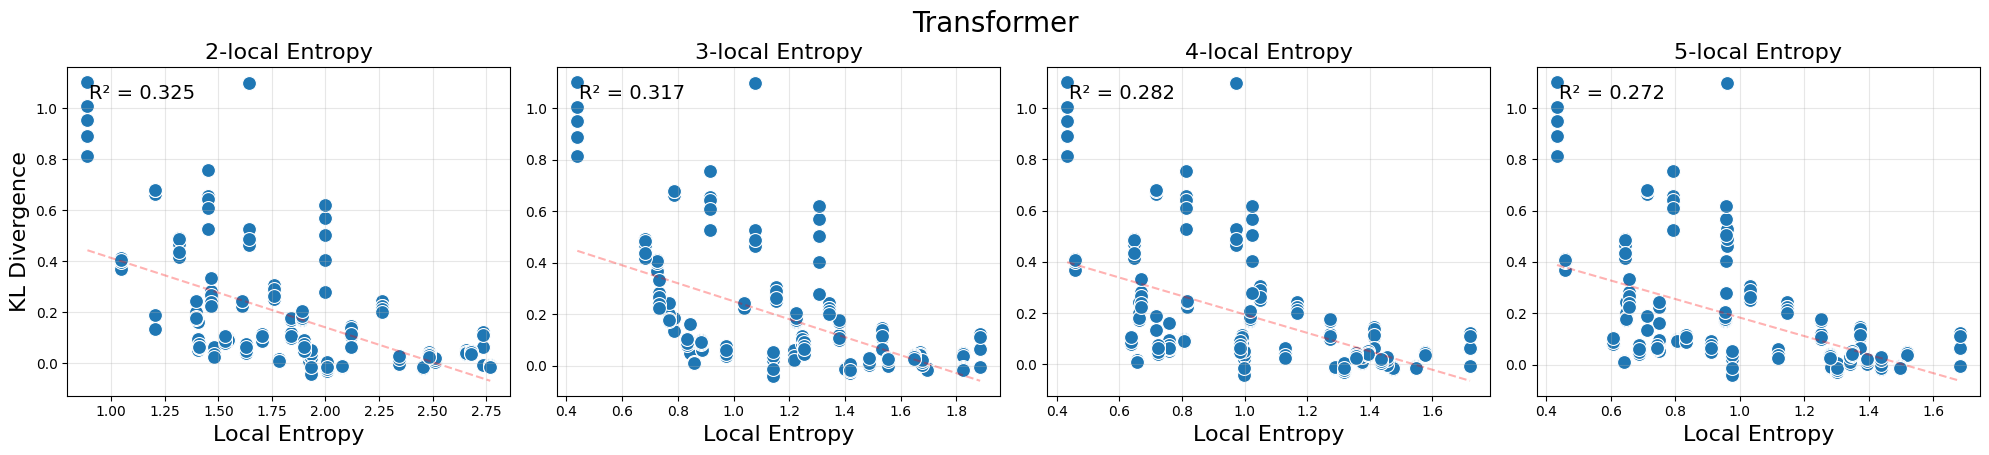

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

estimated = True




ms = [int(col.replace("_local_entropy", "")) for col in merged_result_df.columns if (col.endswith("_local_entropy") and not col.startswith("estimated_"))]

model_name_map = {
    "lstm": "LSTM",
    "transformer": "Transformer",
    "transformer_tiny": "Transformer (Small)",
    "transformer_4layer": "Transformer"
}

for model_name in merged_result_df['model_name'].unique():
    # モデルごとのデータを取得
    model_data = merged_result_df[merged_result_df['model_name'] == model_name]

    # サブプロットの作成
    fig, axes = plt.subplots(1, len(ms), figsize=(5*len(ms), 5))

    for i, m in enumerate(ms):
        # プロット
        sns.scatterplot(
            data=model_data,
            x=f'{m}_local_entropy' if not estimated else f'estimated_{m}_local_entropy',
            y='KL_divergence',  # KLダイバージェンスを使用
            ax=axes[i],
            s=100
        )

        # # エラーバーを追加
        # for _, row in model_data.iterrows():
        #     axes[i].errorbar(
        #         row[f'{m}_local_entropy'],
        #         row['KL_divergence'],  # KLダイバージェンスを使用
        #         yerr=row['sent_cross_entropy_std'],
        #         fmt='none',
        #         ecolor='gray',
        #         alpha=0.5
        #     )

        # Add regression line
        x = model_data[f'{m}_local_entropy' if not estimated else f'estimated_{m}_local_entropy']
        y = model_data['KL_divergence']  # KLダイバージェンスを使用
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        axes[i].plot(line_x, line_y, color='red', linestyle='--', alpha=0.3)

        # Add R² value
        r_squared = r_value**2
        axes[i].text(0.05, 0.95, f'R² = {r_squared:.3f}',
                    transform=axes[i].transAxes,
                    verticalalignment='top',
                    fontsize=14
                    )

        axes[i].set_title(f'{m}-local Entropy', fontsize=16)
        axes[i].set_xlabel(f'Local Entropy', fontsize=16)
        axes[i].set_ylabel('KL Divergence' if i == 0 else '', fontsize=16)  # ラベルを変更
        axes[i].grid(True, alpha=0.3)

    plt.suptitle(f"{model_name_map[model_name]}", fontsize=20, y=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [32]:
# binning with global entropy
merged_result_df['sym_global_entropy']

KeyError: 'sym_global_entropy'

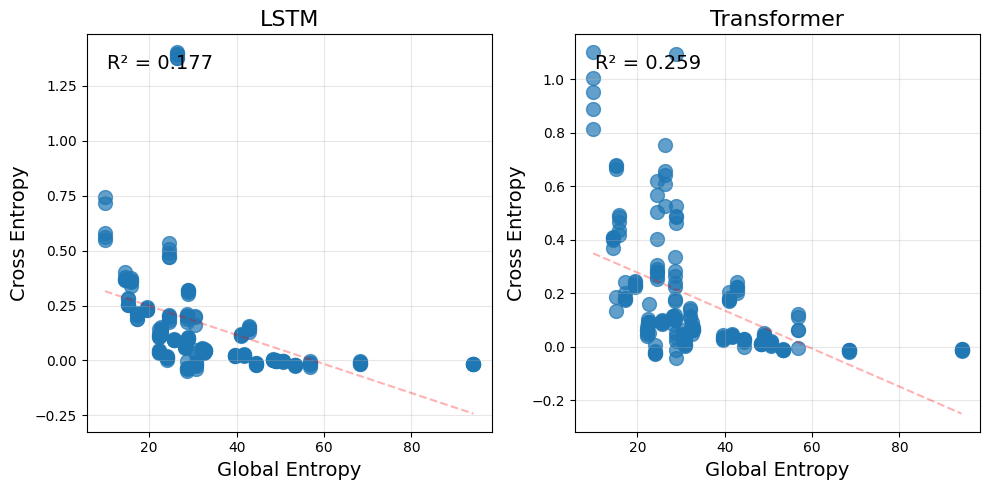

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


# サブプロットの作成
fig, axes = plt.subplots(1, len(merged_result_df['model_name'].unique()),
                        figsize=(5*len(merged_result_df['model_name'].unique()), 5))

# モデルごとにプロット
for i, model_name in enumerate(merged_result_df['model_name'].unique()):
    model_data = merged_result_df[merged_result_df['model_name'] == model_name]

    # Scatter plot
    axes[i].scatter(
        model_data['global_entropy'],
        model_data['KL_divergence'],
        s=100,
        alpha=0.7
    )

    # エラーバー
    # axes[i].errorbar(
    #     model_data['global_entropy'],
    #     model_data['KL_divergence'],
    #     # yerr=model_data['sym_entropy_std'],
    #     fmt='none',
    #     ecolor='gray',
    #     alpha=0.3
    # )

    # 回帰線
    x = model_data['global_entropy']
    y = model_data['KL_divergence']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([x.min(), x.max()])
    line_y = slope * line_x + intercept
    axes[i].plot(line_x, line_y, color='red', linestyle='--', alpha=0.3)

    # R²値を追加
    r_squared = r_value**2
    axes[i].text(0.05, 0.95, f'R² = {r_squared:.3f}',
                transform=axes[i].transAxes,
                verticalalignment='top',
                fontsize=14)

    axes[i].set_title(f'{model_name_map[model_name]}', fontsize=16)
    axes[i].set_xlabel('Global Entropy', fontsize=14)
    axes[i].set_ylabel('Cross Entropy', fontsize=14)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()